# <center>基于拉普拉斯金字塔实现图像融合</center>

## 图像预处理

保证两张待融合的图像尺寸一致。

In [1]:
import numpy
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import copy

#显示用tensor表示的图像
def show_image(image):
    image_plt = copy.deepcopy(image)
    image_plt = image_plt.permute(1, 2, 0).numpy()
    plt.imshow(image_plt)
    plt.axis('off')
    plt.show()

#从本地文件加载图像
def load_image():
    root = tk.Tk()
    root.withdraw()
    filepath = filedialog.askopenfilename(title = "请选择融合的主要图像（融合后的图像以该图像尺寸为准）", filetypes = [("PNG Files", "*.png")])
    if filepath:
        image1 = Image.open(filepath).convert('RGB')
        filepath = filedialog.askopenfilename(title = "请选择融合的次要图像（将拉伸到与主要图像尺寸一致）", filetypes = [("PNG Files", "*.png")])
        if filepath:
            image2 = Image.open(filepath).convert('RGB')
            #将图像转换为tensor
            transform = transforms.Compose([transforms.PILToTensor()])
            image1 = transform(image1)
            height, width = image1.shape[-2:]
            #将image2拉伸到与image1的尺寸一致
            transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize(size = (height, width))])
            image2 = transform(image2)
            #转换为浮点数形式，便于后续操作
            image1 = image1.to(torch.float)
            image1 /= 255
            image2 = image2.to(torch.float)
            image2 /= 255
            return True, image1, image2
        else:
            return False, None, None
    else:
        return False, None, None

## 建立高斯金字塔

拉普拉斯金字塔是基于高斯金字塔实现的。首先实现高斯金字塔的向下采样和向上采样。

In [2]:
#高斯金字塔向下采样
def down_sample(image_in, kernel_size = 5, sigma = 0):
    image = copy.deepcopy(image_in)
    #生成高斯滤波器
    if sigma > 0: #生成高斯分布的卷积核
        kernel = numpy.zeros((kernel_size, kernel_size))
        for x in range(kernel_size):
            for y in range(kernel_size):
                kernel[y, x] = numpy.exp(-(((kernel_size // 2 - y) ** 2 + (kernel_size // 2 - x) ** 2) / (2 * sigma ** 2)))
        kernel /= numpy.sum(kernel)
        size = kernel_size
    else: #使用默认高斯卷积核
        kernel = (1 / 256 * numpy.array([
            [1, 4, 6, 4, 1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4, 6, 4, 1]
        ]))
        size = 5
    gauss_conv = nn.Conv2d(3, 3, kernel_size = size, padding = size // 2, padding_mode = 'replicate', groups = 3, bias = False)
    with torch.no_grad():
        gauss_conv.weight[0] = torch.tensor(kernel)
        gauss_conv.weight[1] = torch.tensor(kernel)
        gauss_conv.weight[2] = torch.tensor(kernel)
        image = gauss_conv(image) #进行高斯滤波
    #向下采样：隔行隔列保留像素
    image = image[:, ::2, ::2]
    return image

#高斯金字塔向上采样
def up_sample(image_in, kernel_size = 5, sigma = 0):
    image = copy.deepcopy(image_in)
    #向上采样：隔行隔列添加0
    height, width = image.shape[-2:]
    null = torch.zeros(3, height * 2, width * 2)
    null[:, ::2, ::2] = image
    #生成高斯滤波器
    if sigma > 0: #生成高斯分布的卷积核
        kernel = numpy.zeros((kernel_size, kernel_size))
        for x in range(kernel_size):
            for y in range(kernel_size):
                kernel[y, x] = numpy.exp(-(((kernel_size // 2 - y) ** 2 + (kernel_size // 2 - x) ** 2) / (2 * sigma ** 2)))
        kernel = kernel * 4 / numpy.sum(kernel) #上采样的卷积核权重是下采样的四倍
        size = kernel_size
    else: #使用默认高斯卷积核
        kernel = (4 / 256 * numpy.array([
            [1, 4, 6, 4, 1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1, 4, 6, 4, 1]
        ]))
        size = 5
    gauss_conv = nn.Conv2d(3, 3, kernel_size = size, padding = size // 2, padding_mode = 'replicate', groups = 3, bias = False)
    with torch.no_grad():
        gauss_conv.weight[0] = torch.tensor(kernel)
        gauss_conv.weight[1] = torch.tensor(kernel)
        gauss_conv.weight[2] = torch.tensor(kernel)
        image = gauss_conv(null) #进行高斯滤波
    return image

#构建高斯金字塔
def gaussian_pyramid(image_in, layers = 6, kernel_size = 5, sigma = 0):
    pyramid = []
    for i in range(layers):
        image_out = down_sample(image_in, kernel_size, sigma)
        pyramid.append(copy.deepcopy(image_out))
        image_in = image_out
    return pyramid

## 建立拉普拉斯金字塔

基于高斯金字塔建立拉普拉斯金字塔，并实现图像重建功能。

In [3]:
#构建拉普拉斯金字塔
def laplacian_pyramid(image_in, layers = 6, kernel_size = 5, sigma = 0):
    gaussian_pyr = gaussian_pyramid(image_in, layers, kernel_size, sigma)
    pyramid = []
    for i in range(layers - 1):
        diff = up_sample(gaussian_pyr[i + 1], kernel_size, sigma)
        if diff.shape[1] != gaussian_pyr[i].shape[1]: #原图高为奇数，上采样后多出一行的像素
            diff = diff[:, :-1, :]
        if diff.shape[2] != gaussian_pyr[i].shape[2]: #原图宽为奇数，上采样后多出一列的像素
            diff = diff[:, :, :-1]
        pyramid.append(gaussian_pyr[i] - diff)
    pyramid.append(gaussian_pyr[layers - 1])
    return pyramid

#利用拉普拉斯金字塔重建图像
def reconstruct(pyramid, kernel_size = 5, sigma = 0):
    layers = len(pyramid)
    gaussian_pyr = [None] * layers
    gaussian_pyr[layers - 1] = pyramid[layers - 1]
    for i in reversed(range(layers - 1)):
        diff = up_sample(gaussian_pyr[i + 1], kernel_size, sigma)
        if diff.shape[1] != pyramid[i].shape[1]: #原图高为奇数，上采样后多出一行的像素
            diff = diff[:, :-1, :]
        if diff.shape[2] != pyramid[i].shape[2]: #原图宽为奇数，上采样后多出一列的像素
            diff = diff[:, :, :-1]
        gaussian_pyr[i] = pyramid[i] + diff
    return gaussian_pyr[0]

## 进行图像融合

选择两张图像，分别建立拉普拉斯金字塔，然后将其拼接，最后重建出融合后的图像。

不使用拉普拉斯金字塔，直接拼接：


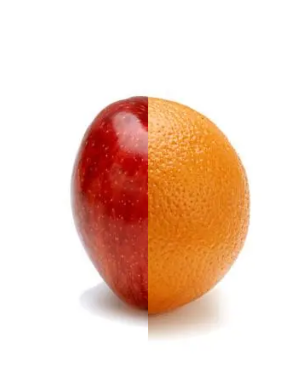

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


使用6层拉普拉斯金字塔进行图像融合：


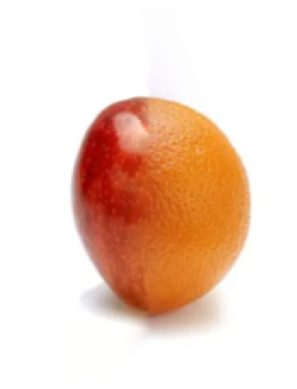

使用size=5, sigma=1的高斯滤波器进行图像融合：


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


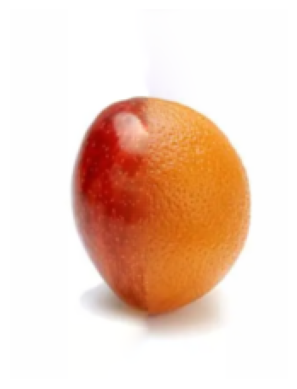

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


使用size=3, sigma=1的高斯滤波器进行图像融合：


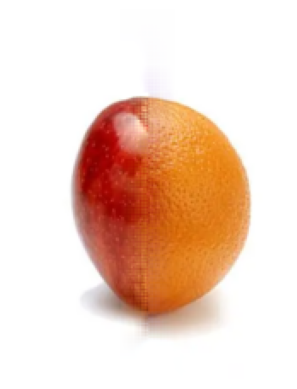

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


使用size=5, sigma=0.5的高斯滤波器进行图像融合：


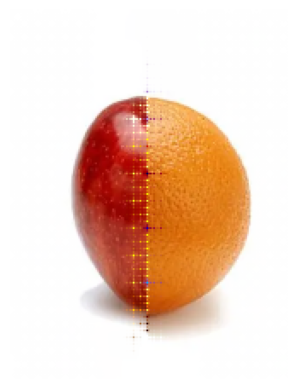

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


使用4层拉普拉斯金字塔进行图像融合：


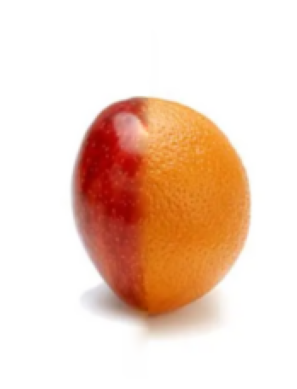

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


使用8层拉普拉斯金字塔进行图像融合：


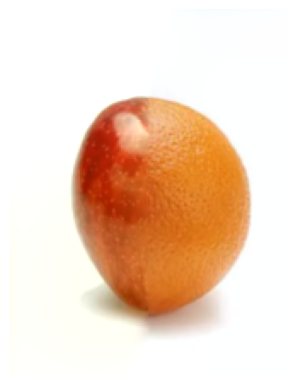

In [4]:
#两张图像分别取左半部和右半部，合成一张新图像（应保证两张图像尺寸一致）
def merge_images(image1, image2):
    if image1.shape == image2.shape:
        height, width = image1.shape[-2:]
        image = torch.zeros(3, height, width)
        image[:, :, :width // 2] = image1[:, :, :width // 2]
        image[:, :, width // 2:] = image2[:, :, width // 2:]
        return image
    else:
        return None

#图像融合
def blend_images(image1, image2, layers = 6, kernel_size = 5, sigma = 0):
    #两张图像分别建立拉普拉斯金字塔
    pyramid1 = laplacian_pyramid(image1, layers, kernel_size, sigma)
    pyramid2 = laplacian_pyramid(image2, layers, kernel_size, sigma)
    #拼接两张图像的拉普拉斯金字塔
    pyramid = []
    for i in range(layers):
        pyramid.append(merge_images(pyramid1[i], pyramid2[i]))
    #根据拼接后的拉普拉斯金字塔重建融合后的图像
    return reconstruct(pyramid, kernel_size, sigma)

flag, image1, image2 = load_image()
if(flag):
    print("不使用拉普拉斯金字塔，直接拼接：")
    show_image(merge_images(image1, image2))
    print("使用6层拉普拉斯金字塔进行图像融合：")
    show_image(blend_images(image1, image2))
    print("使用size=5, sigma=1的高斯滤波器进行图像融合：")
    show_image(blend_images(image1, image2, 6, 5, 1))
    print("使用size=3, sigma=1的高斯滤波器进行图像融合：")
    show_image(blend_images(image1, image2, 6, 3, 1))
    print("使用size=5, sigma=0.5的高斯滤波器进行图像融合：")
    show_image(blend_images(image1, image2, 6, 5, 0.5))
    print("使用4层拉普拉斯金字塔进行图像融合：")
    show_image(blend_images(image1, image2, 4))
    print("使用8层拉普拉斯金字塔进行图像融合：")
    show_image(blend_images(image1, image2, 8))